<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week6/RNN_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**RNN Model dengan TensorFlow : DeteksiSarkasme.json Dataset🤖**

In [1]:
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt


In [3]:
# Load your dataset
import json

with open('/content/Cleaned_DeteksiSarkasme.json') as f:
    data = json.load(f)


In [4]:
# Prepare the headlines and labels
headlines = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]


##PreProcessing

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Data Preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(headlines)  # Fit tokenizer on your data
sequences = tokenizer.texts_to_sequences(headlines)
X = pad_sequences(sequences, maxlen=100)  # Padding sequences to ensure uniform input size
y = np.array(labels)  # Labels as numpy array


In [6]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Build Model

In [7]:
# Build the RNN model
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=hp.Int('embedding_dim', min_value=32, max_value=128, step=32),
                        input_length=100))
    model.add(LSTM(hp.Int('units', min_value=32, max_value=128, step=32)))  # LSTM layer
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (sarcastic or not)

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

##Hyperparameter Tuning wit Keras Tuner

In [8]:
# Hyperparameter tuning with Keras Tuner
tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=10, directory='my_dir', project_name='sarcasm_detection')
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Trial 30 Complete [00h 01m 27s]
val_accuracy: 0.8663421869277954

Best val_accuracy So Far: 0.870086133480072
Total elapsed time: 00h 18m 04s


In [9]:
# Best model summary
best_model = tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     3,796,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,927,809 (14.98 MB)

 Trainable params: 3,927,809 (14.98 MB)

 Non-trainable params: 0 (0.00 B)

##Evaluate

In [10]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [11]:
# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2996
           1       0.85      0.85      0.85      2346

    accuracy                           0.87      5342
   macro avg       0.87      0.87      0.87      5342
weighted avg       0.87      0.87      0.87      5342



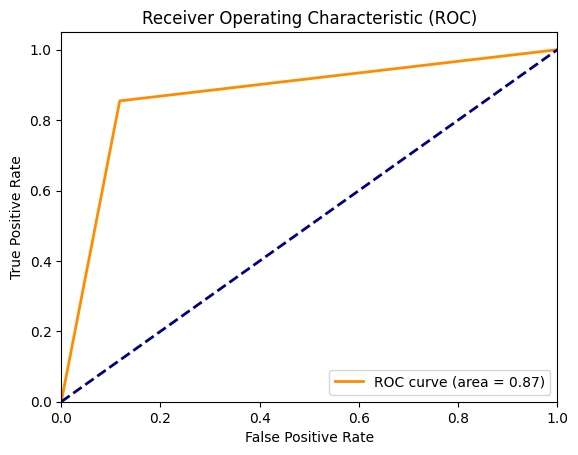

In [12]:
# AUC and ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [13]:
# Training the model with Google Colab's GPU
history = best_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9664 - loss: 0.0993 - val_accuracy: 0.8624 - val_loss: 0.4160
Epoch 2/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9778 - loss: 0.0713 - val_accuracy: 0.8527 - val_loss: 0.4331
Epoch 3/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9848 - loss: 0.0489 - val_accuracy: 0.8491 - val_loss: 0.4620
Epoch 4/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9893 - loss: 0.0339 - val_accuracy: 0.8542 - val_loss: 0.5829
Epoch 5/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9940 - loss: 0.0193 - val_accuracy: 0.8514 - val_loss: 0.6604
Epoch 6/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9967 - loss: 0.0100 - val_accuracy: 0.8482 - val_loss: 0.6822
Epoch 7/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.8521 - val_loss: 0.8910
Epoch 8/10
668/668 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9982 - loss: 0.0044 - val_accur

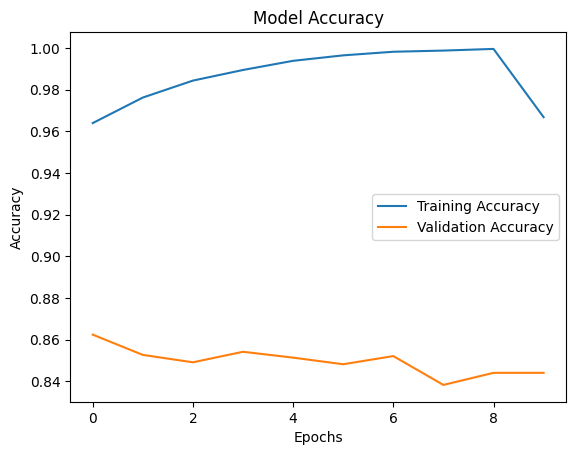

In [14]:
# Plotting accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

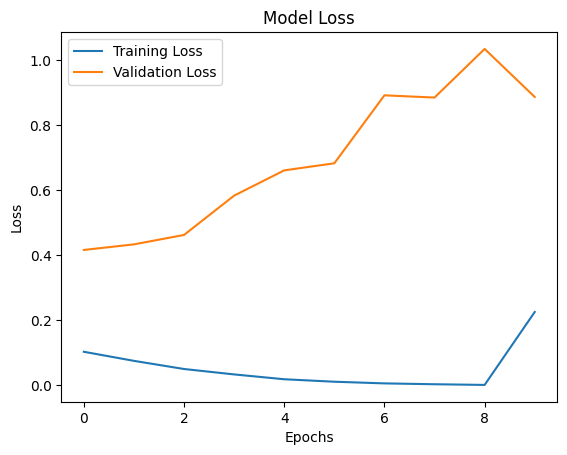

In [15]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()